In [1]:
## Module import
import pandas as pd
import numpy as np

from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

import csv
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

stpwrds = set(stopwords.words('english'))

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vishaljha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
new_sw = set()
with open('../Assets/StopWords_Generic.txt') as f:
    for line in f:
        new_sw.add(line.strip())

stpwrds = stpwrds.union(new_sw)
## Convert all stpwrds to lower case
stpwrds = {word.lower() for word in stpwrds}
len(stpwrds)

180

In [4]:
## Import data
data_loc = '../Data/'
df = pd.read_csv(data_loc + 'bitcoin_cleaned.csv')

In [5]:
## Function to tokenise and lemmatise tweets and remove stopwords
def tokenise_lemmatise(tweet):
    '''
    Function to tokenise and lemmatise tweets and remove stopwords
    '''
    tweet = tweet.lower()
    tokens = word_tokenize(tweet)
    tokens = [w for w in tokens if not w in stpwrds]
    tokens = [w for w in tokens if w.isalpha()]
    ps = PorterStemmer()
    tokens = [ps.stem(w) for w in tokens]
    wnl = WordNetLemmatizer()
    tokens = [wnl.lemmatize(w) for w in tokens]
    return tokens

df['tokens'] = df['tweet'].apply(tokenise_lemmatise)
df['tokens'] = df['tokens'].apply(lambda x: ' '.join(x))
df.head()

,date,timezone,tweet,nlikes,nreplies,nretweets,date_,time,tokens
0,2022-01-23 18:31:55,530.0,@NFDoges Thank you for the airdrop opportunity...,0.0,0.0,0.0,2022-01-23,18:31:55,nfdoge thank airdrop opportun suspport crypto ...
1,2022-01-23 18:31:54,530.0,"Imo this is how #bitcoin looks now, isn't the ...",0.0,0.0,0.0,2022-01-23,18:31:54,imo bitcoin look best view still aliv mayb pan...
2,2022-01-23 18:31:52,530.0,While 2020 and 2021 are considered the years o...,0.0,0.0,0.0,2022-01-23,18:31:52,consid year bitcoin institut adopt digitalasse...
3,2022-01-23 18:31:52,530.0,#bitcoin crash wipes billions off crypto marke...,0.0,0.0,0.0,2022-01-23,18:31:52,bitcoin crash wipe billion crypto market http ...
4,2022-01-23 18:31:51,530.0,@binance Bitcoin,0.0,0.0,0.0,2022-01-23,18:31:51,binanc bitcoin


In [6]:
# USING LOUGHRAN MCDONALD'S MODEL TO NUMBER POSITIVE AND NEGATIVE TWEETS
word_dict_file = pd.read_csv('../Assets/LoughranMcDonald_MasterDictionary_2020.csv')

pos_word_list = []
neg_word_list = []
for i in range(len(word_dict_file)):
    if word_dict_file['Positive'][i] > 0:
        pos_word_list.append(word_dict_file['Word'][i])
    elif word_dict_file['Negative'][i] > 0:
        neg_word_list.append(word_dict_file['Word'][i])

pos_word_list = [x.lower() for x in pos_word_list]
neg_word_list = [x.lower() for x in neg_word_list]

print(len(pos_word_list))
print(len(neg_word_list))

347
2345


In [7]:
## Function to calculate the score (positive/negative) of the tweet using the word_dict
def calculate_score_helper(tweet):
    '''
    Utility function to calculate the score (positive/negative) of the tweet using the word_dict
    '''
    pos_score = 0
    neg_score = 0
    for word in tweet:
        if word in pos_word_list:
            pos_score += 1
        elif word in neg_word_list:
            neg_score += 1
    score = pos_score - neg_score
    return score

def calculate_score(df):
    '''
    Utility function to calculate the score (positive/negative) of the tweet using the word_dict
    '''
    df['LMD_score'] = df['tokens'].apply(calculate_score_helper)
    return df

df = calculate_score(df)
df.head()

,date,timezone,tweet,nlikes,nreplies,nretweets,date_,time,tokens,LMD_score
0,2022-01-23 18:31:55,530.0,@NFDoges Thank you for the airdrop opportunity...,0.0,0.0,0.0,2022-01-23,18:31:55,nfdoge thank airdrop opportun suspport crypto ...,0
1,2022-01-23 18:31:54,530.0,"Imo this is how #bitcoin looks now, isn't the ...",0.0,0.0,0.0,2022-01-23,18:31:54,imo bitcoin look best view still aliv mayb pan...,0
2,2022-01-23 18:31:52,530.0,While 2020 and 2021 are considered the years o...,0.0,0.0,0.0,2022-01-23,18:31:52,consid year bitcoin institut adopt digitalasse...,0
3,2022-01-23 18:31:52,530.0,#bitcoin crash wipes billions off crypto marke...,0.0,0.0,0.0,2022-01-23,18:31:52,bitcoin crash wipe billion crypto market http ...,0
4,2022-01-23 18:31:51,530.0,@binance Bitcoin,0.0,0.0,0.0,2022-01-23,18:31:51,binanc bitcoin,0


In [8]:
## Function to calculate the sentiment of the tweet using TextBlob using polarity and subjectivity
def calculate_sentiment_helper(tweet):
    '''
    Utility function to calculate the sentiment of the tweet using TextBlob using polarity and subjectivity
    '''
    blob = TextBlob(tweet)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

def calculate_sentiment(df):
    '''
    Utility function to calculate the sentiment of the tweet using TextBlob using polarity and subjectivity
    '''
    df['sentiment_polarity'], df['sentiment_subjectivity'] = zip(*df['tokens'].apply(calculate_sentiment_helper))
    return df

df = calculate_sentiment(df)
df.head()

,date,timezone,tweet,nlikes,nreplies,nretweets,date_,time,tokens,LMD_score,sentiment_polarity,sentiment_subjectivity
0,2022-01-23 18:31:55,530.0,@NFDoges Thank you for the airdrop opportunity...,0.0,0.0,0.0,2022-01-23,18:31:55,nfdoge thank airdrop opportun suspport crypto ...,0,0.0,0.0
1,2022-01-23 18:31:54,530.0,"Imo this is how #bitcoin looks now, isn't the ...",0.0,0.0,0.0,2022-01-23,18:31:54,imo bitcoin look best view still aliv mayb pan...,0,1.0,0.3
2,2022-01-23 18:31:52,530.0,While 2020 and 2021 are considered the years o...,0.0,0.0,0.0,2022-01-23,18:31:52,consid year bitcoin institut adopt digitalasse...,0,0.0,0.0
3,2022-01-23 18:31:52,530.0,#bitcoin crash wipes billions off crypto marke...,0.0,0.0,0.0,2022-01-23,18:31:52,bitcoin crash wipe billion crypto market http ...,0,0.0,0.0
4,2022-01-23 18:31:51,530.0,@binance Bitcoin,0.0,0.0,0.0,2022-01-23,18:31:51,binanc bitcoin,0,0.0,0.0


In [9]:
## Get a sentiment score from 0 to 1 for each tweet using the sentiment polarity and subjectivity
def get_sentiment_score(df):
    '''
    Get a sentiment score from 0 to 1 for each tweet using the sentiment polarity and subjectivity
    '''
    df['sentiment_score'] = df['sentiment_polarity'] + df['sentiment_subjectivity']
    return df

df = get_sentiment_score(df)
df.head()

,date,timezone,tweet,nlikes,nreplies,nretweets,date_,time,tokens,LMD_score,sentiment_polarity,sentiment_subjectivity,sentiment_score
0,2022-01-23 18:31:55,530.0,@NFDoges Thank you for the airdrop opportunity...,0.0,0.0,0.0,2022-01-23,18:31:55,nfdoge thank airdrop opportun suspport crypto ...,0,0.0,0.0,0.0
1,2022-01-23 18:31:54,530.0,"Imo this is how #bitcoin looks now, isn't the ...",0.0,0.0,0.0,2022-01-23,18:31:54,imo bitcoin look best view still aliv mayb pan...,0,1.0,0.3,1.3
2,2022-01-23 18:31:52,530.0,While 2020 and 2021 are considered the years o...,0.0,0.0,0.0,2022-01-23,18:31:52,consid year bitcoin institut adopt digitalasse...,0,0.0,0.0,0.0
3,2022-01-23 18:31:52,530.0,#bitcoin crash wipes billions off crypto marke...,0.0,0.0,0.0,2022-01-23,18:31:52,bitcoin crash wipe billion crypto market http ...,0,0.0,0.0,0.0
4,2022-01-23 18:31:51,530.0,@binance Bitcoin,0.0,0.0,0.0,2022-01-23,18:31:51,binanc bitcoin,0,0.0,0.0,0.0


In [10]:
## Get average sentiment score for each tweet using the LMD score and sentiment score
def get_average_sentiment_score(df):
    '''
    Get average sentiment score for each tweet using the LMD score and sentiment score
    '''
    df['avg_sentiment_score'] = (df['LMD_score'] + df['sentiment_score']) / 2
    return df

df = get_average_sentiment_score(df)
df.head()

,date,timezone,tweet,nlikes,nreplies,nretweets,date_,time,tokens,LMD_score,sentiment_polarity,sentiment_subjectivity,sentiment_score,avg_sentiment_score
0,2022-01-23 18:31:55,530.0,@NFDoges Thank you for the airdrop opportunity...,0.0,0.0,0.0,2022-01-23,18:31:55,nfdoge thank airdrop opportun suspport crypto ...,0,0.0,0.0,0.0,0.00
1,2022-01-23 18:31:54,530.0,"Imo this is how #bitcoin looks now, isn't the ...",0.0,0.0,0.0,2022-01-23,18:31:54,imo bitcoin look best view still aliv mayb pan...,0,1.0,0.3,1.3,0.65
2,2022-01-23 18:31:52,530.0,While 2020 and 2021 are considered the years o...,0.0,0.0,0.0,2022-01-23,18:31:52,consid year bitcoin institut adopt digitalasse...,0,0.0,0.0,0.0,0.00
3,2022-01-23 18:31:52,530.0,#bitcoin crash wipes billions off crypto marke...,0.0,0.0,0.0,2022-01-23,18:31:52,bitcoin crash wipe billion crypto market http ...,0,0.0,0.0,0.0,0.00
4,2022-01-23 18:31:51,530.0,@binance Bitcoin,0.0,0.0,0.0,2022-01-23,18:31:51,binanc bitcoin,0,0.0,0.0,0.0,0.00


In [11]:
## Multiply the average sentiment score by nreplies and nretweets to get the final score, then normalise the score to -1 to 1
def get_final_score(df):
    '''
    Multiply the average sentiment score by nreplies and nretweets to get the final score, then normalise the score
    '''
    df['final_score'] = df['avg_sentiment_score'] * (df['nreplies'] + df['nretweets']/2)
    df['final_score'] = df['final_score'] / df['final_score'].abs().max()    
  
    return df

df = get_final_score(df)
df.head()

,date,timezone,tweet,nlikes,nreplies,nretweets,date_,time,tokens,LMD_score,sentiment_polarity,sentiment_subjectivity,sentiment_score,avg_sentiment_score,final_score
0,2022-01-23 18:31:55,530.0,@NFDoges Thank you for the airdrop opportunity...,0.0,0.0,0.0,2022-01-23,18:31:55,nfdoge thank airdrop opportun suspport crypto ...,0,0.0,0.0,0.0,0.00,0.0
1,2022-01-23 18:31:54,530.0,"Imo this is how #bitcoin looks now, isn't the ...",0.0,0.0,0.0,2022-01-23,18:31:54,imo bitcoin look best view still aliv mayb pan...,0,1.0,0.3,1.3,0.65,0.0
2,2022-01-23 18:31:52,530.0,While 2020 and 2021 are considered the years o...,0.0,0.0,0.0,2022-01-23,18:31:52,consid year bitcoin institut adopt digitalasse...,0,0.0,0.0,0.0,0.00,0.0
3,2022-01-23 18:31:52,530.0,#bitcoin crash wipes billions off crypto marke...,0.0,0.0,0.0,2022-01-23,18:31:52,bitcoin crash wipe billion crypto market http ...,0,0.0,0.0,0.0,0.00,0.0
4,2022-01-23 18:31:51,530.0,@binance Bitcoin,0.0,0.0,0.0,2022-01-23,18:31:51,binanc bitcoin,0,0.0,0.0,0.0,0.00,0.0


In [12]:
## Drop all cols except final_score, tweet, time and date
df = df[['final_score', 'tweet', 'time', 'date']]
df.head()

,final_score,tweet,time,date
0,0.0,@NFDoges Thank you for the airdrop opportunity...,18:31:55,2022-01-23 18:31:55
1,0.0,"Imo this is how #bitcoin looks now, isn't the ...",18:31:54,2022-01-23 18:31:54
2,0.0,While 2020 and 2021 are considered the years o...,18:31:52,2022-01-23 18:31:52
3,0.0,#bitcoin crash wipes billions off crypto marke...,18:31:52,2022-01-23 18:31:52
4,0.0,@binance Bitcoin,18:31:51,2022-01-23 18:31:51


In [13]:
## Sort the dataframe by time
df = df.sort_values(by=['time'])
df.head()

,final_score,tweet,time,date
12344,0.000000,Opinion: Does Bitcoin Magazine create valuable...,12:37:45,2022-01-23 12:37:45
12343,0.000000,@glyph @eevee @jlazaroff Also needs to learn B...,12:37:50,2022-01-23 12:37:50
12342,0.000000,@RaoulGMI Previous cycles at 800 days before t...,12:37:51,2022-01-23 12:37:51
12341,0.000475,Bitcoin 1-day social activity: Galaxy Score™ ...,12:37:52,2022-01-23 12:37:52
12340,0.000000,Is this me or Everyone who don’t have money to...,12:38:00,2022-01-23 12:38:00


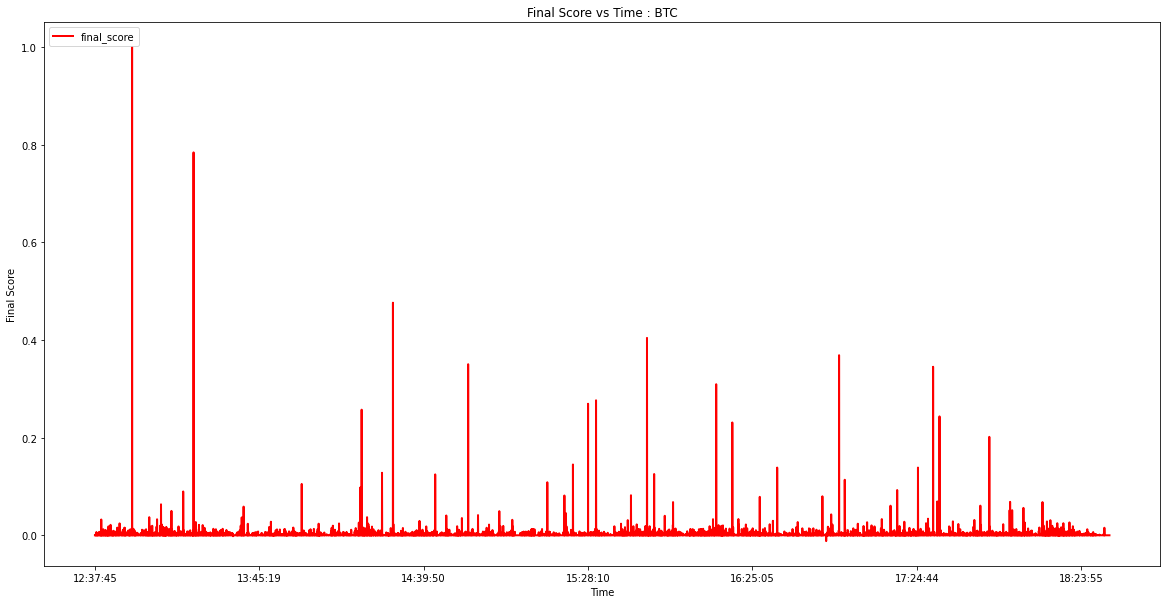

In [14]:
## Plot the final score vs time as a line graph using matplotlib
plot = df.plot(x='time', y='final_score', figsize=(20,10), color='red', linewidth=2, legend=True)
plot.set_xlabel('Time')
plot.set_ylabel('Final Score')
plot.set_title('Final Score vs Time : BTC')
plot.legend(loc='upper left')



In [15]:
## Calculate the average final score for every 5 minutes
def get_avg_final_score(df):
    '''
    Calculate the average final score for every 5 minutes
    '''
    df['1_min_window_score'] = df['final_score'].rolling(window=1).mean()
    return df
df = get_avg_final_score(df)
df.head()


,final_score,tweet,time,date,1_min_window_score
12344,0.000000,Opinion: Does Bitcoin Magazine create valuable...,12:37:45,2022-01-23 12:37:45,0.000000
12343,0.000000,@glyph @eevee @jlazaroff Also needs to learn B...,12:37:50,2022-01-23 12:37:50,0.000000
12342,0.000000,@RaoulGMI Previous cycles at 800 days before t...,12:37:51,2022-01-23 12:37:51,0.000000
12341,0.000475,Bitcoin 1-day social activity: Galaxy Score™ ...,12:37:52,2022-01-23 12:37:52,0.000475
12340,0.000000,Is this me or Everyone who don’t have money to...,12:38:00,2022-01-23 12:38:00,0.000000


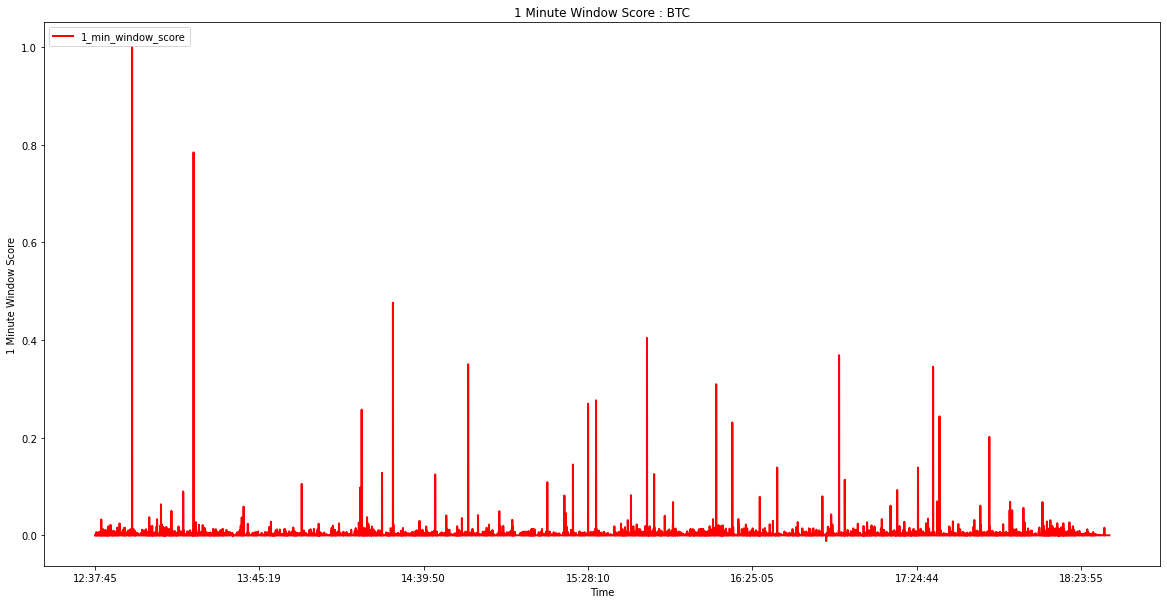

In [19]:
## Plot the 1 minute window score using matplotlib as a value vs time graph
plot = df.plot(x='time', y='1_min_window_score', figsize=(20,10), color='red', linewidth=2, legend=True)
plot.set_xlabel('Time')
plot.set_ylabel('1 Minute Window Score')
plot.set_title('1 Minute Window Score : BTC')
plot.legend(loc='upper left')

In [20]:
## Export the dataframe to a csv file
df.to_csv('../Data/BTC_final_score.csv', index=False)